## Imports

In [35]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
# plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import confusion_matrix, \
                            recall_score, accuracy_score, \
                            roc_curve, roc_auc_score, \
                            auc, \
                            RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier

from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier.rocauc import roc_auc

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

from code.model_verification import model_scoring

%matplotlib inline

In [2]:
sns.set()
sns.set(font_scale=2)

Import the `fetal_health.csv` data set, which is available
[here, via kaggle](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification)  
<sup>kaggle data set was obtained via this research - 
[Ayres de Campos et al. (2000) SisPorto 2.0 A Program for Automated Analysis of Cardiotocograms. J Matern Fetal Med 5:311-318](https://onlinelibrary.wiley.com/doi/10.1002/1520-6661(200009/10)9:5%3C311::AID-MFM12%3E3.0.CO;2-9)</sup>

In [3]:
fetal_df = pd.read_csv('./data/fetal_health.csv')

In [4]:
fetal_df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [5]:
print(fetal_df.info(), \
    f"""\n\n
    Data shape: {fetal_df.shape}
    Total nulls in data set: {fetal_df.isna().sum().sum()}
    """)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

There are no nulls in this data set ... may not need to impute any data

all data is float64, may have some categories to pull out (such as
fetal health)

In [6]:
# display the columns that seem like they could be made
# into categorical variables, possibly at least 

print(f"""
{fetal_df.value_counts('fetal_health')}

{fetal_df.value_counts('histogram_number_of_peaks')}

{fetal_df.value_counts('histogram_number_of_zeroes')}
""")


fetal_health
1.0    1655
2.0     295
3.0     176
dtype: int64

histogram_number_of_peaks
1.0     357
2.0     331
3.0     269
4.0     258
5.0     210
6.0     158
7.0     145
0.0     107
8.0     106
9.0      67
10.0     49
11.0     28
12.0     22
13.0     10
14.0      5
16.0      2
15.0      1
18.0      1
dtype: int64

histogram_number_of_zeroes
0.0     1624
1.0      366
2.0      108
3.0       21
5.0        2
4.0        2
10.0       1
8.0        1
7.0        1
dtype: int64



The only column that seems to be able to be broken down into
a categorical value is the fetal_health column. 

### Checking the values

In [7]:
print(fetal_df.value_counts('fetal_health') , '\n\n' , fetal_df.value_counts('fetal_health', normalize=True))

fetal_health
1.0    1655
2.0     295
3.0     176
dtype: int64 

 fetal_health
1.0    0.778457
2.0    0.138758
3.0    0.082785
dtype: float64


From the [description of values in the dataset](./data/fetal_health_descriptions.md),
the values are heavily imbalanced in favor of "Normal" health.
1. Normal
2. Suspect
3. Pathological

## Determining the measure

Because the health of a child and mother are important,
the measure that this project will be employing will be
recall. It is imperative that as many suspect or
pathological cases are found as possible. An accidental
flag or false positive is more acceptable than missing
the cases where an issue is present.

This project will focus on maximizing the recall score
in an attempt to most accurately predict cases where a
pregnancy is showing potential signs of issues.

## Additional Data Preparation
### Defining X and y, creating splits

In [8]:
X = fetal_df.drop(columns=['fetal_health'])
y = fetal_df['fetal_health']

In [9]:
# we will stratify on the y values here to ensure that
# the proportion of the test and train data remains
# mostly the same, this is mostly to make sure that our
# test data actually has some of the values we are 
# targeting 
X_train, X_test, y_train, y_test = train_test_split(
                    X, y, random_state=1,
                    test_size=0.2, stratify=y
)

## Creating and Validating the Dummy Model

In [10]:
dummy_baseline = DummyClassifier(strategy='most_frequent')
dummy_baseline.fit(X_train,y_train)

DummyClassifier(strategy='most_frequent')

In [11]:
y_train_preds = dummy_baseline.predict(X_train)
y_train_preds

array([1., 1., 1., ..., 1., 1., 1.])

In [12]:
y_train

1391    1.0
926     1.0
111     1.0
1207    1.0
897     1.0
       ... 
2027    3.0
441     1.0
1449    1.0
1512    1.0
789     1.0
Name: fetal_health, Length: 1700, dtype: float64

In [13]:
# ConfusionMatrixDisplay?

(array([0, 1, 2]),
 [Text(0, 0, 'Healthy'), Text(1, 0, 'Suspect'), Text(2, 0, 'Pathological')])

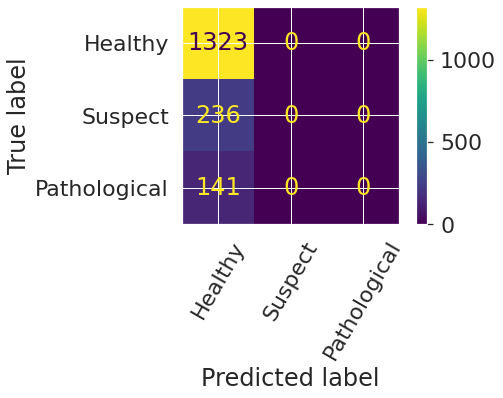

In [14]:
fig, ax = plt.subplots()

ConfusionMatrixDisplay.from_estimator(dummy_baseline,X_train,y_train,
    ax=ax
    #labels={1:'Healthy',2:'Suspect',3:'Pathological'}
    );

ax.set(
    yticklabels=['Healthy','Suspect','Pathological'],
    xticklabels=['Healthy','Suspect','Pathological']
);
plt.xticks(rotation=60)

Visually, we can see that the 2 labels we care about are
entirely incorrectly predicted. We'll want to over-sample
our target values to improve our predictions on them.

We'll go ahead and start creating our initial models from
here.

## Initial Models

Throughout this process, we will be using SMOTE to
perform our over-sampling. We'll perform this process
within a pipeline and will 

## Approach 1: KNN

In [39]:
initial_knn_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('o',SMOTE(random_state=1,sampling_strategy='auto')),

    ('knn',KNeighborsClassifier(n_neighbors=5, n_jobs=-2))
])

In [41]:
initial_knn_pipeline.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()), ('o', SMOTE(random_state=1)),
                ('knn', KNeighborsClassifier(n_jobs=-2))])

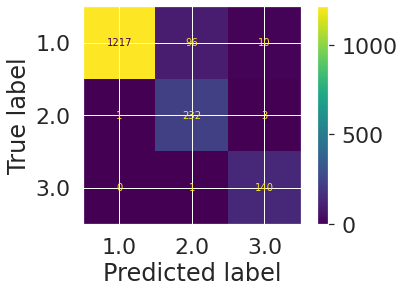

In [42]:
ConfusionMatrixDisplay.from_estimator(initial_knn_pipeline,X_train,y_train);


Initial Model recall: 0.9652792372040908
Median ROC AUC score: 0.9980725145473125
    


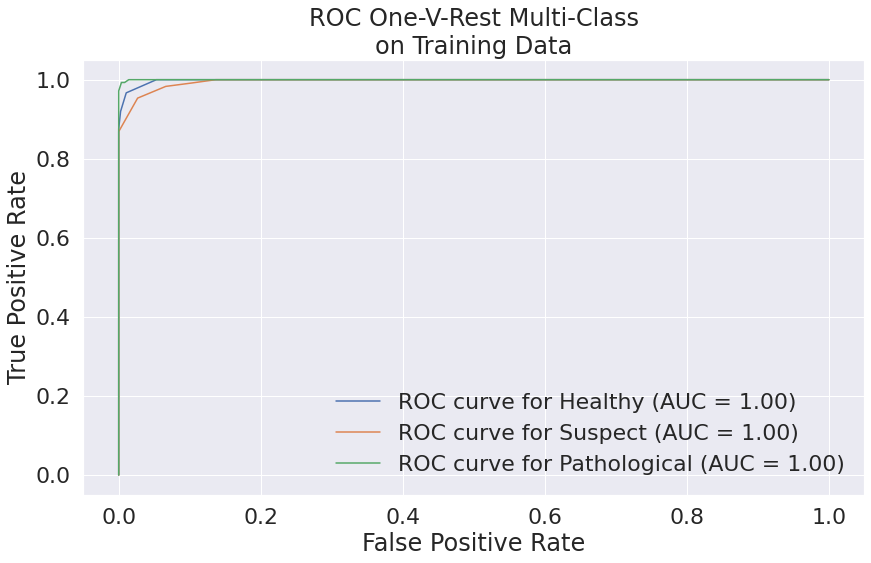

In [43]:
fig, ax = plt.subplots(figsize=(14,8))
model_scoring(initial_knn_pipeline,X_train,y_train,average='macro',
                        plot_curve=True, ax=ax,
                        class_names=['Healthy','Suspect','Pathological'])

ax.set(
    title="ROC One-V-Rest Multi-Class\non Training Data"
)

'';

In [55]:
knn_params = {
    'o__sampling_strategy':['auto','all'],
    'knn__n_neighbors':[3,5,7],
    'knn__p':[2,3]
}

In [58]:
knn_gs = GridSearchCV(
    initial_knn_pipeline,
    param_grid=knn_params,
    n_jobs=-2,verbose=3
)

In [59]:
knn_gs.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('o', SMOTE(random_state=1)),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-2))]),
             n_jobs=-2,
             param_grid={'knn__n_neighbors': [3, 5, 7], 'knn__p': [2, 3],
                         'o__sampling_strategy': ['auto', 'all']},
             verbose=3)

In [62]:
knn_gs.best_params_ , knn_gs.best_estimator_ , knn_gs.best_score_

({'knn__n_neighbors': 3, 'knn__p': 2, 'o__sampling_strategy': 'auto'},
 Pipeline(steps=[('ss', StandardScaler()), ('o', SMOTE(random_state=1)),
                 ('knn', KNeighborsClassifier(n_jobs=-2, n_neighbors=3))]),
 0.886470588235294)

## Approach 2: Random Forest

### Creating the Initial Model

In [15]:
initial_tree_pipeline = imbPipeline(steps=[
    ('ss',StandardScaler()),

    ('o',SMOTE(random_state=1,sampling_strategy='auto')),

    ('rfc',RandomForestClassifier(random_state=1,
                max_depth=5, n_jobs=-2))
])

In [16]:
initial_tree_pipeline.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()), ('o', SMOTE(random_state=1)),
                ('rfc',
                 RandomForestClassifier(max_depth=5, n_jobs=-2,
                                        random_state=1))])

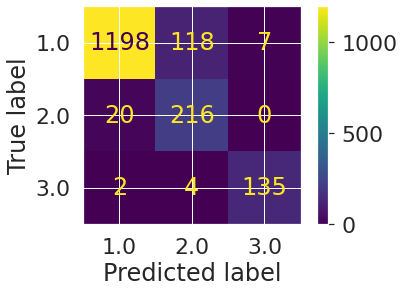

In [17]:
ConfusionMatrixDisplay.from_estimator(initial_tree_pipeline,X_train,y_train);


Initial Model recall: 0.9260729361531314
Median ROC AUC score: 0.9849576125520768
    


[Text(0.5, 1.0, 'ROC One-V-Rest Multi-Class\non Training Data')]

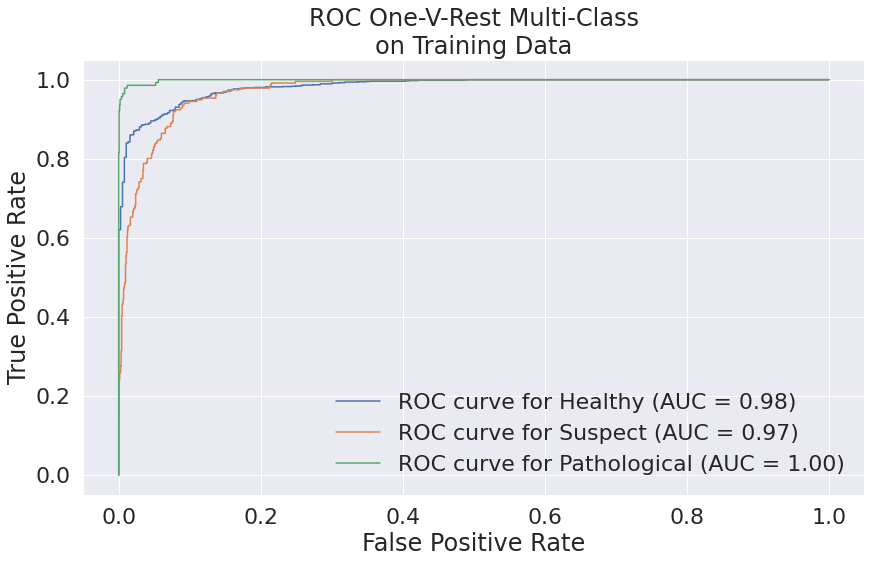

In [22]:
fig, ax = plt.subplots(figsize=(14,8))
model_scoring(initial_tree_pipeline,X_train,y_train,average='macro',
                        plot_curve=True, ax=ax,
                        class_names=['Healthy','Suspect','Pathological'])

ax.set(
    title="ROC One-V-Rest Multi-Class\non Training Data"
)

'';

The initial model has a decent recall score at ~92.6% with
a median auc roc score of 98.5%



In [ ]:
# initial_tree_pipeline = imbPipeline(steps=[
#     ('ss',StandardScaler()),

#     ('o',SMOTE(random_state=1,sampling_strategy='auto')),

#     ('rfc',RandomForestClassifier(random_state=1,
#                 max_depth=5, n_jobs=-2))
# ])

In [25]:
tree_params = {
    'o__sampling_strategy':['auto','all'],
    'rfc__max_depth': [3,5,7],
    'rfc__min_samples_split': [2,4,6]
}

In [32]:
tree_gs = GridSearchCV(
    initial_tree_pipeline,
    param_grid=tree_params,
    n_jobs=-2, verbose=3
)

In [34]:
tree_gs.fit(X_train,y_train)
tree_gs.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'o__sampling_strategy': 'auto',
 'rfc__max_depth': 7,
 'rfc__min_samples_split': 4}